# Advanced Lane Line Detections on the Road

The processes are the following

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera Calibration Matrix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


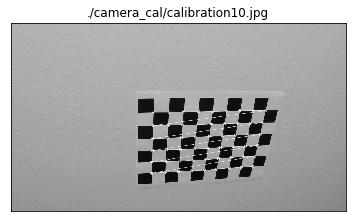

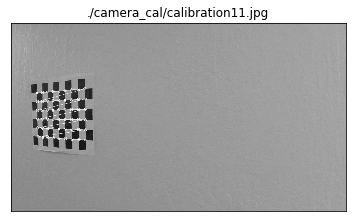

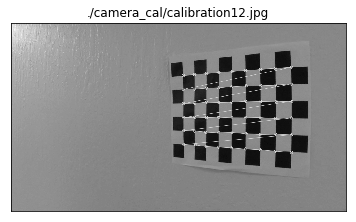

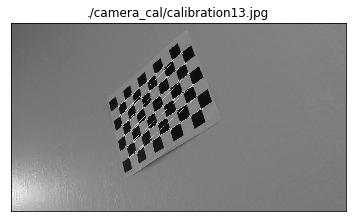

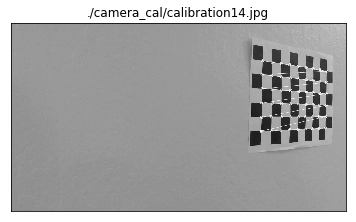

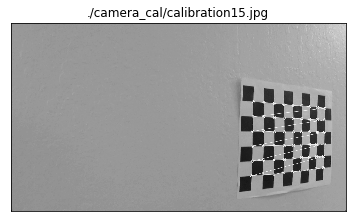

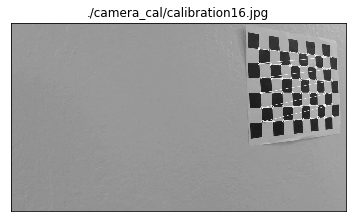

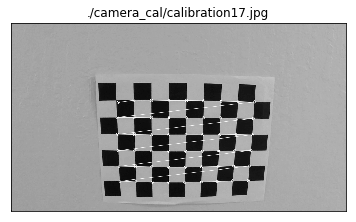

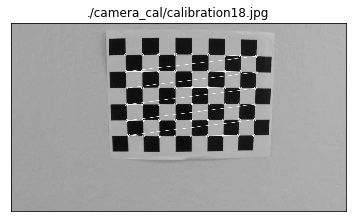

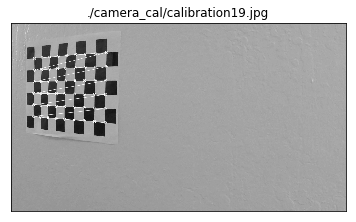

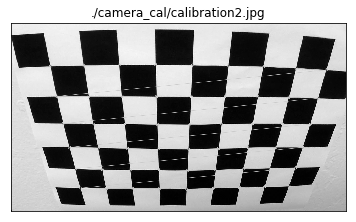

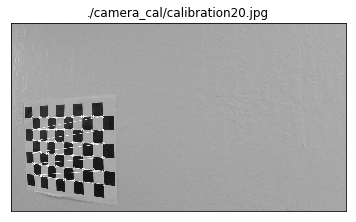

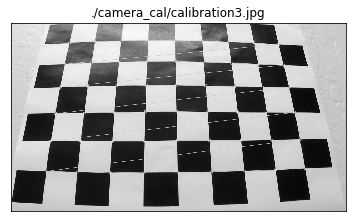

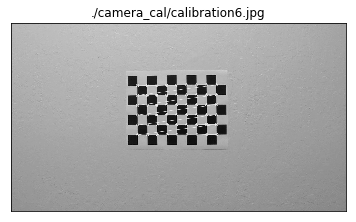

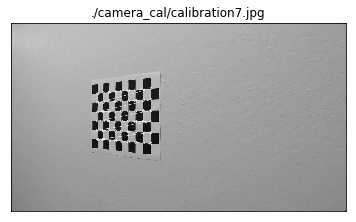

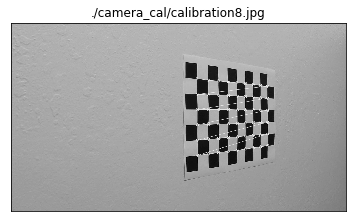

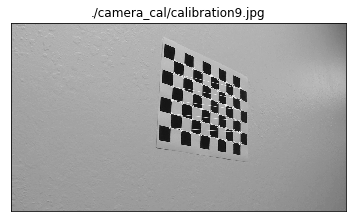

In [2]:
images = glob.glob('./camera_cal/calibration*.jpg')

#print('images:\n', images)

#plt.figure(figsize=(20, 100))

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(img, (9,6), None)
    
    if ret == True: 
        objpoints.append(objp)
        imgpoints.append(corners)
        
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.title(fname)
        fig = plt.imshow(img, cmap = "gray")
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
        cv2.imwrite('./output_images/calibrate{:02d}.jpg'.format(i), img)
        #plt.savefig('./output_images/calibrate{:02d}.jpg'.format(i))
        

## Distortion Correction

In [3]:
images = glob.glob('./camera_cal/calibration*.jpg')
print('images:\n', images)

images:
 ['./camera_cal/calibration1.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration9.jpg']


In [4]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

images:
 ['./camera_cal/calibration1.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration9.jpg']


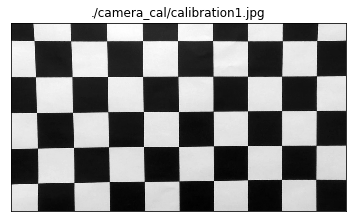

In [5]:
print('images:\n', images)

for i, fname in enumerate(images[:1]):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img, mtx, dist = cal_undistort(img, objpoints, imgpoints)
    #img = warp(img)
     
    plt.figure()
    plt.title(fname)
    fig = plt.imshow(img, cmap = "gray")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    cv2.imwrite('./output_images/warp{:02d}.jpg'.format(i), img)
    #plt.savefig('./output_images/warp{:02d}.jpg'.format(i))

## Create Thresholded Bianary Image 

In [6]:
images = glob.glob('./test_images/*.jpg')
print(images)

['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg', './test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']


In [7]:
def dir_thresh(img, thresh=(0, np.pi/2), kernel_size=3):
    
    abs_sobel = np.zeros_like(img)
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)
        
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    #print('absgraddir:', absgraddir)
    
    binary_output = np.zeros_like(absgraddir)
    binary_output = np.int8(binary_output)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    #print('binary output:', binary_output.shape, binary_output)
    
    return binary_output
    

In [8]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=5, thresh=(0,255)):
    
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

In [9]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
     
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output


In [14]:
def combined(img):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    thresh = (50, 255)
    binary = np.zeros_like(S)
    
    thresh = (50, 255)
    binary = np.zeros_like(S)
    #binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    img = S
    
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(15, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(100, 255))
    dir_binary = dir_thresh(img, kernel_size=ksize, thresh=(1., np.pi/2 ))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    img = combined.copy()
    img = cv2.convertScaleAbs(img, alpha=(255.0))
 
    #fig.axes.get_xaxis().set_visible(False)
    #fig.axes.get_yaxis().set_visible(False)
    
    return img
    
    #plt.savefig('./output_images/thresh{:02d}.jpg'.format(i))
    

images:
 ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg', './test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']


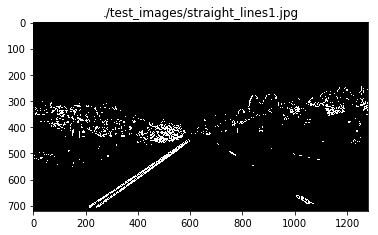

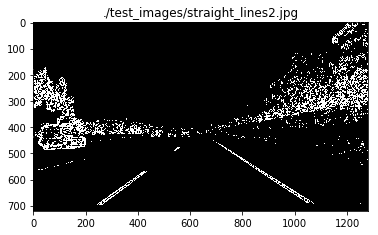

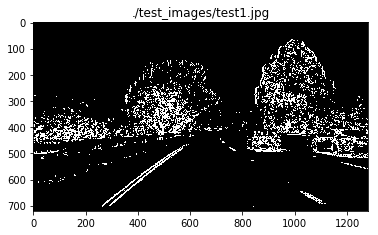

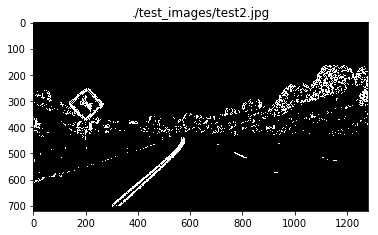

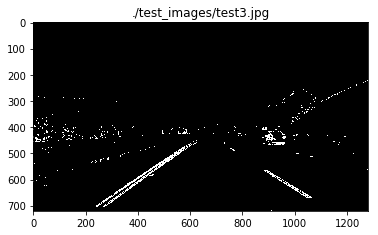

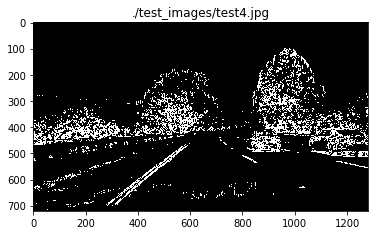

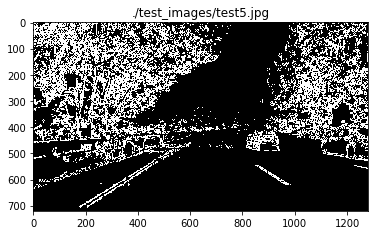

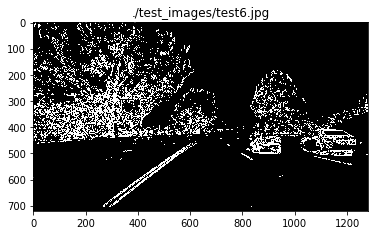

In [15]:
print('images:\n', images)

#plt.figure(figsize=(20, 100))
ksize = 3

for i, fname in enumerate(images):
    img = cv2.imread(fname)
   
    img = combined(img)
    
    cv2.imwrite('./output_images/thresh{:02d}.jpg'.format(i), img )
    plt.figure()
    plt.title(fname)
    fig = plt.imshow(img, cmap = "gray")

## Perspective Transformation to Have a Birds-Eye View

In [16]:
images = glob.glob('./test_images/*.jpg')
print(images)

['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg', './test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']


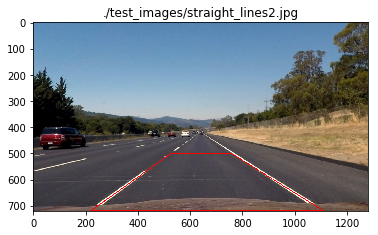

In [17]:
# Manually set the source area

fname = images[1]
img = plt.imread(fname).copy()
img = cv2.undistort(img, mtx, dist, None, mtx)

clr = [255, 0, 0]
width = 2

pos1 = (527, 500)  #  (597, 450)
pos2 = (757, 500)  # (687, 450)
pos3 = (1110, 719)
pos4 = (220, 719)


cv2.line(img, pos1, pos2, clr, width)
cv2.line(img, pos2, pos3, clr, width)
cv2.line(img, pos3, pos4, clr, width)
cv2.line(img, pos4, pos1, clr, width)

plt.figure()
plt.title(fname)
fig = plt.imshow(img)

In [18]:
def perspective(img):
    
    clr = [255, 0, 0]
    width = 2

    pos1 = (527, 500)  #  (597, 450)
    pos2 = (757, 500)  # (687, 450)
    pos3 = (1110, 719)
    pos4 = (220, 719)
    
    cv2.line(img, pos1, pos2, clr, width)
    cv2.line(img, pos2, pos3, clr, width)
    cv2.line(img, pos3, pos4, clr, width)
    cv2.line(img, pos4, pos1, clr, width)
    
    src = np.float32( 
    [[pos1[0], pos1[1]],
     [pos2[0], pos2[1]],
     [pos3[0], pos3[1]],
     [pos4[0], pos4[1]],
    ])

    img_size = img.shape
    #print(img_size)
    offset = 200
    dst = np.float32([[offset, -offset],
                  [img_size[0] + offset , - offset], 
                  [img_size[0] + offset, img_size[1] - offset], 
                  [offset, img_size[1] - offset ]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]))
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

    
    return warped, M, Minv


In [19]:
warped, M, Minv = perspective(img)

In [20]:
images = glob.glob('./output_images/thresh*.jpg')
print(images)

['./output_images/thresh00.jpg', './output_images/thresh01.jpg', './output_images/thresh02.jpg', './output_images/thresh03.jpg', './output_images/thresh04.jpg', './output_images/thresh05.jpg', './output_images/thresh06.jpg', './output_images/thresh07.jpg']


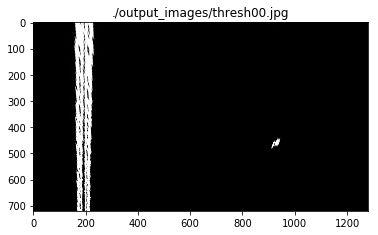

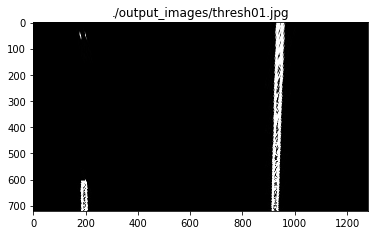

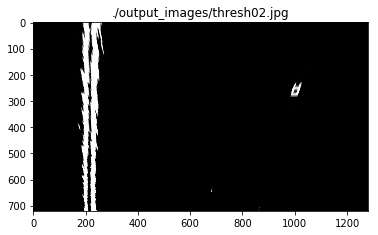

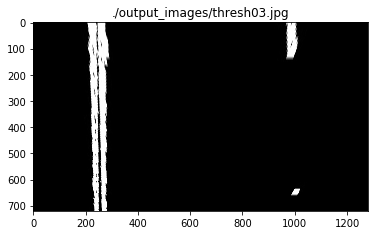

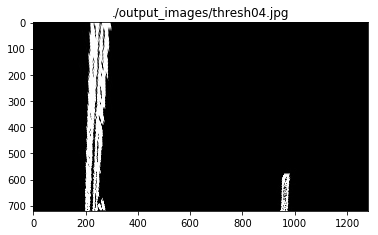

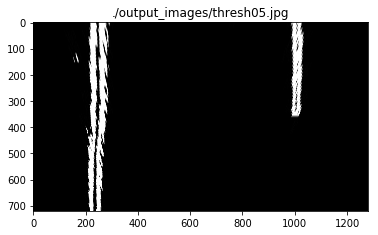

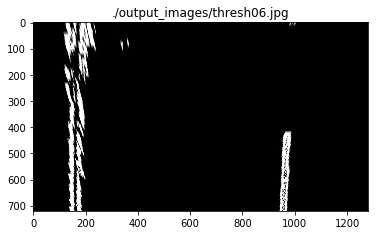

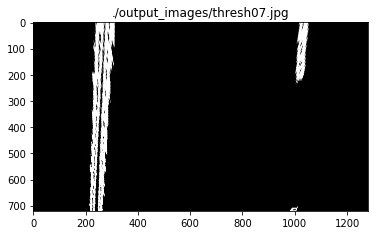

In [21]:
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = img.shape

    warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]))
    
    img = warped
    
    plt.figure()
    plt.title(fname)
    plt.imshow(img, cmap = "gray")
    
    cv2.imwrite('./output_images/warped_road{:02d}.jpg'.format(i), img )

## Detect Lane Pixes and Fit to Find the Lane Boundry

In [22]:
images = glob.glob('./output_images/warped_road*.jpg')
print(images)

['./output_images/warped_road00.jpg', './output_images/warped_road01.jpg', './output_images/warped_road02.jpg', './output_images/warped_road03.jpg', './output_images/warped_road04.jpg', './output_images/warped_road05.jpg', './output_images/warped_road06.jpg', './output_images/warped_road07.jpg']


In [23]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

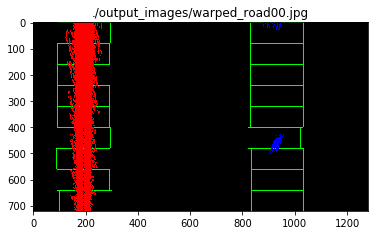

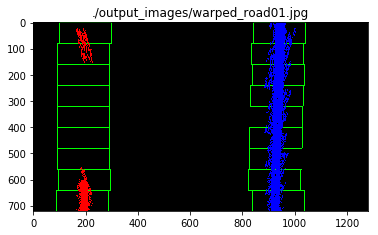

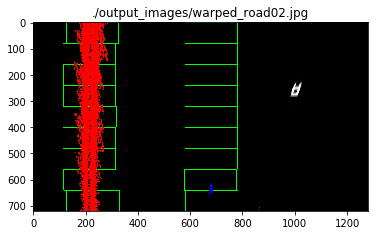

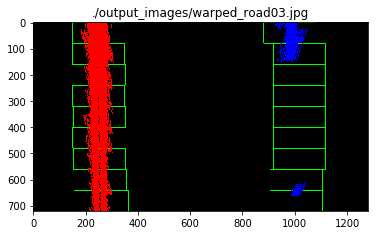

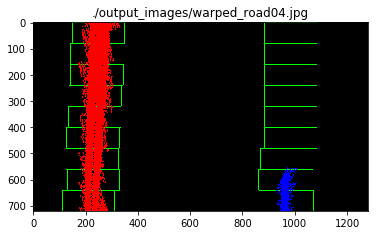

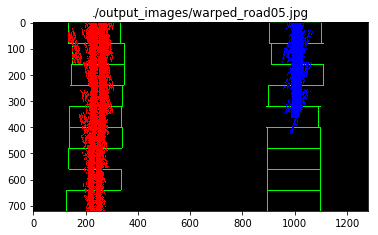

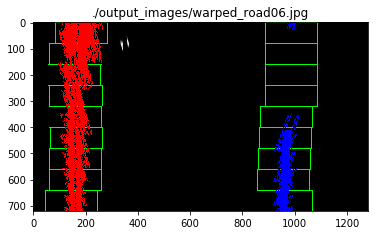

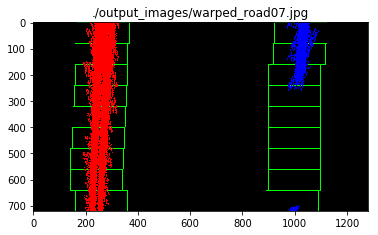

In [24]:
fits = []

for i, fname in enumerate(images):

    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    out_img, left_fit, right_fit = fit_polynomial(img)
    
    fits.append([left_fit, right_fit])

    plt.title(fname)
    plt.imshow(out_img)
    
    plt.figure()
    
    cv2.imwrite('./output_images/fit_line{:02d}.jpg'.format(i), out_img )


## Determine the curvature of the lane and vehicle position with respect to center.

In [25]:
def calculate(img, left_fit, right_fit, ym_per_pix=30/720, xm_per_pix=3.7/700):
    
    y_eval = img.shape[1]
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    vehicle_posi = img.shape[0] / 2 

    left_line = left_fit[0] * img.shape[0]**2 +  left_fit[1] * img.shape[0] + left_fit[2]
    right_line = right_fit[0] * img.shape[0]**2 +  right_fit[1] * img.shape[0] + right_fit[2]

    line_center = (left_line + right_line)/2  

    vehicle_bias = (line_center - vehicle_posi) * xm_per_pix
    
    return left_curverad, right_curverad, vehicle_bias
    

In [26]:
images = glob.glob('./output_images/fit_line*.jpg')
print(images)

img = cv2.imread(fname)

['./output_images/fit_line00.jpg', './output_images/fit_line01.jpg', './output_images/fit_line02.jpg', './output_images/fit_line03.jpg', './output_images/fit_line04.jpg', './output_images/fit_line05.jpg', './output_images/fit_line06.jpg', './output_images/fit_line07.jpg']


In [27]:
left_curverad, right_curverad, vehicle_bias = calculate(img, left_fit, right_fit)

print(left_curverad, right_curverad, vehicle_bias)

54551.7986321 5738.04584727 1.3669346644


## Warp the detected lane boundaries back onto the original image
## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [28]:
images = glob.glob('./test_images/*.jpg')
print(images)

['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg', './test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']


In [29]:
def overlay(img, left_fit, right_fit):
    
    warp = np.zeros_like(img).astype(np.uint8)
    
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x_left = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
    x_right = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]
    
    x_left_pts = np.array([np.transpose(np.vstack([x_left, y]))])
    x_right_pts = np.array([np.flipud(np.transpose(np.vstack([x_right, y])))])
    
    pts = np.hstack((x_left_pts, x_right_pts))
    cv2.fillPoly(warp, np.int_([pts]), (0,255, 0))
    
    warp = cv2.warpPerspective(warp, Minv, (img.shape[1], img.shape[0])) 
    
    
    integ = cv2.addWeighted(img, 1, warp, 0.3, 0)
    
    
    # Calculation 
    
    left_curverad, right_curverad, vehicle_bias = calculate(img, left_fit, right_fit, ym_per_pix=30/720, xm_per_pix=3.7/700)
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)
    size=2
    cv2.putText(integ, 'Left lane curvature: {:.0f} m'.format(left_curverad), (20, 50), font, size, color, 2)
    cv2.putText(integ, 'Right lane curvature: {:.0f} m'.format(right_curverad), (20, 110), font, size, color, 2)
    cv2.putText(integ, 'Vehicle posi {:.2f}m'.format(vehicle_bias), (20, 170), font, size, color, 2)
    
    
    return integ

In [30]:
for i, fname in enumerate(images):
    
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    left_fit, right_fit = fits[i]
    
    img = overlay(img, left_fit, right_fit)
    

## Pipeline of All Above

In [42]:
left_fit_prev = None
right_fit_prev = None

def pipeline(img, M):
    
    global left_fit_prev
    global right_fit_prev
    
    img_orig = img.copy()
    img = combined(img)
            
    img = cv2.warpPerspective(img, M, (img_size[1], img_size[0]))
    
    try:
        img, left_fit, right_fit = fit_polynomial(img)
        left_fit_prev = left_fit
        right_fit_prev = right_fit
    except: 
        left_fit = left_fit_prev
        right_fit = right_fit_prev

      
    integ = overlay(img_orig, left_fit, right_fit)
       
    return integ
    
    

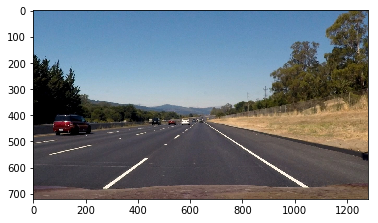

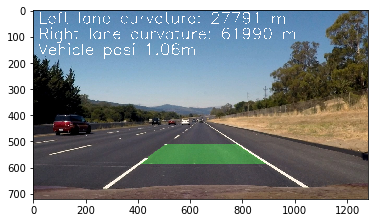

In [43]:
images = glob.glob('./test_images/*.jpg')
fname = images[1]

img = plt.imread(fname).copy()

plt.figure()
plt.imshow(img)

img = pipeline(img, M)

plt.figure()
plt.imshow(img)

## Pipeline on Video

In [44]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [45]:
def process_image(image):
    
    result = pipeline(image, M)
    
    return result

In [46]:
video_output = 'test_videos_output/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<03:48,  5.50it/s]


  0%|          | 2/1261 [00:00<03:54,  5.37it/s]


  0%|          | 3/1261 [00:00<03:52,  5.41it/s]


  0%|          | 4/1261 [00:00<04:05,  5.11it/s]


  0%|          | 5/1261 [00:01<04:54,  4.26it/s]


  0%|          | 6/1261 [00:01<04:43,  4.43it/s]


  1%|          | 7/1261 [00:01<05:01,  4.16it/s]


  1%|          | 8/1261 [00:01<05:26,  3.83it/s]


  1%|          | 9/1261 [00:02<05:04,  4.11it/s]


  1%|          | 10/1261 [00:02<04:44,  4.40it/s]


  1%|          | 11/1261 [00:02<04:19,  4.82it/s]


  1%|          | 12/1261 [00:02<04:02,  5.15it/s]


  1%|          | 13/1261 [00:02<04:30,  4.61it/s]


  1%|          | 14/1261 [00:03<05:08,  4.04it/s]


  1%|          | 15/1261 [00:03<04:52,  4.26it/s]


  1%|▏         | 16/1261 [00:03<04:28,  4.64it/s]


  1%|▏         | 17/1261 [00:03<04:09,  4.98it/s]


  1%|▏         | 18/1261 [00:03<03:54,  5.31it/s]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [00:25<03:58,  4.73it/s]


 11%|█         | 135/1261 [00:26<03:53,  4.83it/s]


 11%|█         | 136/1261 [00:26<03:51,  4.87it/s]


 11%|█         | 137/1261 [00:26<03:52,  4.83it/s]


 11%|█         | 138/1261 [00:26<03:39,  5.12it/s]


 11%|█         | 139/1261 [00:26<03:43,  5.02it/s]


 11%|█         | 140/1261 [00:27<03:44,  5.00it/s]


 11%|█         | 141/1261 [00:27<03:38,  5.13it/s]


 11%|█▏        | 142/1261 [00:27<03:50,  4.86it/s]


 11%|█▏        | 143/1261 [00:27<03:55,  4.75it/s]


 11%|█▏        | 144/1261 [00:27<03:49,  4.88it/s]


 11%|█▏        | 145/1261 [00:28<04:05,  4.55it/s]


 12%|█▏        | 146/1261 [00:28<03:59,  4.65it/s]


 12%|█▏        | 147/1261 [00:28<04:01,  4.61it/s]


 12%|█▏        | 148/1261 [00:28<03:55,  4.72it/s]


 12%|█▏        | 149/1261 [00:29<03:52,  4.79it/s]


 12%|█▏        | 150/1261 [00:29<03:56,  4.69it/s]


 12%|█▏        | 151/1261 [00:29<04:02,  4.58it/s]


 12%|█▏        | 152/1261 [00:29<03:56,  4.69i

 21%|██        | 266/1261 [00:57<04:20,  3.83it/s]


 21%|██        | 267/1261 [00:57<04:28,  3.70it/s]


 21%|██▏       | 268/1261 [00:57<04:21,  3.79it/s]


 21%|██▏       | 269/1261 [00:58<04:29,  3.69it/s]


 21%|██▏       | 270/1261 [00:58<04:23,  3.76it/s]


 21%|██▏       | 271/1261 [00:58<04:19,  3.82it/s]


 22%|██▏       | 272/1261 [00:58<04:14,  3.89it/s]


 22%|██▏       | 273/1261 [00:59<04:20,  3.79it/s]


 22%|██▏       | 274/1261 [00:59<04:14,  3.88it/s]


 22%|██▏       | 275/1261 [00:59<04:09,  3.95it/s]


 22%|██▏       | 276/1261 [00:59<04:05,  4.01it/s]


 22%|██▏       | 277/1261 [01:00<04:01,  4.07it/s]


 22%|██▏       | 278/1261 [01:00<04:04,  4.02it/s]


 22%|██▏       | 279/1261 [01:00<04:02,  4.05it/s]


 22%|██▏       | 280/1261 [01:00<03:57,  4.13it/s]


 22%|██▏       | 281/1261 [01:01<04:05,  4.00it/s]


 22%|██▏       | 282/1261 [01:01<04:02,  4.03it/s]


 22%|██▏       | 283/1261 [01:01<04:12,  3.88it/s]


 23%|██▎       | 284/1261 [01:01<04:01,  4.04i

 32%|███▏      | 398/1261 [01:30<03:40,  3.92it/s]


 32%|███▏      | 399/1261 [01:30<03:29,  4.11it/s]


 32%|███▏      | 400/1261 [01:30<03:29,  4.11it/s]


 32%|███▏      | 401/1261 [01:31<03:34,  4.02it/s]


 32%|███▏      | 402/1261 [01:31<03:35,  3.98it/s]


 32%|███▏      | 403/1261 [01:31<03:23,  4.21it/s]


 32%|███▏      | 404/1261 [01:31<03:24,  4.19it/s]


 32%|███▏      | 405/1261 [01:32<03:30,  4.07it/s]


 32%|███▏      | 406/1261 [01:32<03:36,  3.95it/s]


 32%|███▏      | 407/1261 [01:32<03:26,  4.14it/s]


 32%|███▏      | 408/1261 [01:32<03:29,  4.07it/s]


 32%|███▏      | 409/1261 [01:33<03:30,  4.05it/s]


 33%|███▎      | 410/1261 [01:33<03:22,  4.20it/s]


 33%|███▎      | 411/1261 [01:33<03:13,  4.39it/s]


 33%|███▎      | 412/1261 [01:33<03:23,  4.18it/s]


 33%|███▎      | 413/1261 [01:33<03:24,  4.14it/s]


 33%|███▎      | 414/1261 [01:34<03:25,  4.13it/s]


 33%|███▎      | 415/1261 [01:34<03:18,  4.27it/s]


 33%|███▎      | 416/1261 [01:34<03:22,  4.18i

 42%|████▏     | 530/1261 [02:05<03:28,  3.50it/s]


 42%|████▏     | 531/1261 [02:05<03:22,  3.60it/s]


 42%|████▏     | 532/1261 [02:05<03:21,  3.62it/s]


 42%|████▏     | 533/1261 [02:06<03:22,  3.59it/s]


 42%|████▏     | 534/1261 [02:06<03:17,  3.68it/s]


 42%|████▏     | 535/1261 [02:06<03:13,  3.75it/s]


 43%|████▎     | 536/1261 [02:06<03:21,  3.60it/s]


 43%|████▎     | 537/1261 [02:07<03:23,  3.55it/s]


 43%|████▎     | 538/1261 [02:07<03:20,  3.60it/s]


 43%|████▎     | 539/1261 [02:07<03:17,  3.65it/s]


 43%|████▎     | 540/1261 [02:07<03:21,  3.58it/s]


 43%|████▎     | 541/1261 [02:08<03:18,  3.63it/s]


 43%|████▎     | 542/1261 [02:08<03:21,  3.58it/s]


 43%|████▎     | 543/1261 [02:08<03:36,  3.32it/s]


 43%|████▎     | 544/1261 [02:09<03:36,  3.31it/s]


 43%|████▎     | 545/1261 [02:09<03:27,  3.45it/s]


 43%|████▎     | 546/1261 [02:09<03:27,  3.44it/s]


 43%|████▎     | 547/1261 [02:10<03:32,  3.36it/s]


 43%|████▎     | 548/1261 [02:10<03:27,  3.43i

 52%|█████▏    | 662/1261 [02:42<02:50,  3.52it/s]


 53%|█████▎    | 663/1261 [02:43<02:49,  3.54it/s]


 53%|█████▎    | 664/1261 [02:43<02:47,  3.57it/s]


 53%|█████▎    | 665/1261 [02:43<02:49,  3.51it/s]


 53%|█████▎    | 666/1261 [02:43<02:49,  3.51it/s]


 53%|█████▎    | 667/1261 [02:44<02:47,  3.54it/s]


 53%|█████▎    | 668/1261 [02:44<02:42,  3.66it/s]


 53%|█████▎    | 669/1261 [02:44<02:43,  3.63it/s]


 53%|█████▎    | 670/1261 [02:44<02:41,  3.67it/s]


 53%|█████▎    | 671/1261 [02:45<02:42,  3.64it/s]


 53%|█████▎    | 672/1261 [02:45<02:41,  3.66it/s]


 53%|█████▎    | 673/1261 [02:45<02:40,  3.67it/s]


 53%|█████▎    | 674/1261 [02:46<02:39,  3.67it/s]


 54%|█████▎    | 675/1261 [02:46<02:38,  3.69it/s]


 54%|█████▎    | 676/1261 [02:46<02:33,  3.81it/s]


 54%|█████▎    | 677/1261 [02:46<02:35,  3.75it/s]


 54%|█████▍    | 678/1261 [02:47<02:34,  3.77it/s]


 54%|█████▍    | 679/1261 [02:47<02:33,  3.80it/s]


 54%|█████▍    | 680/1261 [02:47<02:34,  3.77i

 63%|██████▎   | 794/1261 [03:19<02:15,  3.44it/s]


 63%|██████▎   | 795/1261 [03:19<02:15,  3.45it/s]


 63%|██████▎   | 796/1261 [03:19<02:13,  3.49it/s]


 63%|██████▎   | 797/1261 [03:20<02:08,  3.61it/s]


 63%|██████▎   | 798/1261 [03:20<02:08,  3.60it/s]


 63%|██████▎   | 799/1261 [03:20<02:08,  3.59it/s]


 63%|██████▎   | 800/1261 [03:20<02:03,  3.72it/s]


 64%|██████▎   | 801/1261 [03:21<02:00,  3.82it/s]


 64%|██████▎   | 802/1261 [03:21<02:04,  3.69it/s]


 64%|██████▎   | 803/1261 [03:21<02:10,  3.51it/s]


 64%|██████▍   | 804/1261 [03:22<02:11,  3.49it/s]


 64%|██████▍   | 805/1261 [03:22<02:04,  3.66it/s]


 64%|██████▍   | 806/1261 [03:22<02:00,  3.78it/s]


 64%|██████▍   | 807/1261 [03:22<02:04,  3.65it/s]


 64%|██████▍   | 808/1261 [03:23<02:06,  3.59it/s]


 64%|██████▍   | 809/1261 [03:23<02:03,  3.66it/s]


 64%|██████▍   | 810/1261 [03:23<01:59,  3.77it/s]


 64%|██████▍   | 811/1261 [03:23<02:07,  3.52it/s]


 64%|██████▍   | 812/1261 [03:24<02:09,  3.47i

 73%|███████▎  | 926/1261 [03:56<01:36,  3.49it/s]


 74%|███████▎  | 927/1261 [03:56<01:32,  3.61it/s]


 74%|███████▎  | 928/1261 [03:56<01:29,  3.74it/s]


 74%|███████▎  | 929/1261 [03:57<01:30,  3.67it/s]


 74%|███████▍  | 930/1261 [03:57<01:31,  3.60it/s]


 74%|███████▍  | 931/1261 [03:57<01:32,  3.58it/s]


 74%|███████▍  | 932/1261 [03:57<01:29,  3.67it/s]


 74%|███████▍  | 933/1261 [03:58<01:27,  3.74it/s]


 74%|███████▍  | 934/1261 [03:58<01:30,  3.63it/s]


 74%|███████▍  | 935/1261 [03:58<01:30,  3.60it/s]


 74%|███████▍  | 936/1261 [03:58<01:27,  3.73it/s]


 74%|███████▍  | 937/1261 [03:59<01:22,  3.91it/s]


 74%|███████▍  | 938/1261 [03:59<01:28,  3.64it/s]


 74%|███████▍  | 939/1261 [03:59<01:31,  3.54it/s]


 75%|███████▍  | 940/1261 [04:00<01:27,  3.67it/s]


 75%|███████▍  | 941/1261 [04:00<01:27,  3.67it/s]


 75%|███████▍  | 942/1261 [04:00<01:52,  2.84it/s]


 75%|███████▍  | 943/1261 [04:01<01:49,  2.92it/s]


 75%|███████▍  | 944/1261 [04:01<01:42,  3.10i

 84%|████████▍ | 1057/1261 [04:36<01:02,  3.24it/s]


 84%|████████▍ | 1058/1261 [04:37<01:01,  3.30it/s]


 84%|████████▍ | 1059/1261 [04:37<01:01,  3.30it/s]


 84%|████████▍ | 1060/1261 [04:37<00:59,  3.40it/s]


 84%|████████▍ | 1061/1261 [04:38<00:58,  3.43it/s]


 84%|████████▍ | 1062/1261 [04:38<00:58,  3.40it/s]


 84%|████████▍ | 1063/1261 [04:38<00:59,  3.33it/s]


 84%|████████▍ | 1064/1261 [04:39<00:57,  3.41it/s]


 84%|████████▍ | 1065/1261 [04:39<00:56,  3.46it/s]


 85%|████████▍ | 1066/1261 [04:39<00:57,  3.41it/s]


 85%|████████▍ | 1067/1261 [04:39<00:57,  3.38it/s]


 85%|████████▍ | 1068/1261 [04:40<00:55,  3.49it/s]


 85%|████████▍ | 1069/1261 [04:40<00:54,  3.51it/s]


 85%|████████▍ | 1070/1261 [04:40<00:56,  3.37it/s]


 85%|████████▍ | 1071/1261 [04:41<00:58,  3.27it/s]


 85%|████████▌ | 1072/1261 [04:41<00:57,  3.31it/s]


 85%|████████▌ | 1073/1261 [04:41<00:55,  3.40it/s]


 85%|████████▌ | 1074/1261 [04:41<00:56,  3.32it/s]


 85%|████████▌ | 1075/1261 [

 94%|█████████▍| 1187/1261 [05:25<01:05,  1.12it/s]


 94%|█████████▍| 1188/1261 [05:25<01:02,  1.17it/s]


 94%|█████████▍| 1189/1261 [05:26<01:01,  1.17it/s]


 94%|█████████▍| 1190/1261 [05:27<01:07,  1.05it/s]


 94%|█████████▍| 1191/1261 [05:28<01:08,  1.02it/s]


 95%|█████████▍| 1192/1261 [05:30<01:11,  1.04s/it]


 95%|█████████▍| 1193/1261 [05:30<01:04,  1.05it/s]


 95%|█████████▍| 1194/1261 [05:31<00:57,  1.16it/s]


 95%|█████████▍| 1195/1261 [05:32<00:51,  1.28it/s]


 95%|█████████▍| 1196/1261 [05:32<00:48,  1.34it/s]


 95%|█████████▍| 1197/1261 [05:33<00:45,  1.40it/s]


 95%|█████████▌| 1198/1261 [05:34<00:43,  1.46it/s]


 95%|█████████▌| 1199/1261 [05:34<00:44,  1.38it/s]


 95%|█████████▌| 1200/1261 [05:35<00:43,  1.42it/s]


 95%|█████████▌| 1201/1261 [05:36<00:40,  1.48it/s]


 95%|█████████▌| 1202/1261 [05:36<00:39,  1.50it/s]


 95%|█████████▌| 1203/1261 [05:37<00:44,  1.31it/s]


 95%|█████████▌| 1204/1261 [05:38<00:44,  1.27it/s]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 5min 30s, sys: 56.1 s, total: 6min 26s
Wall time: 6min 29s
